In [1]:
%matplotlib notebook
%reload_ext autoreload
%autoreload 2

import sys
import os
import itertools
import time

import numpy as np
from numpy import linalg
from scipy import spatial
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
plt.rcParams.update({'figure.max_open_warning': 0})

In [24]:
MIN_DET = 1e-10

def build(X, verbose=True):
    """
    Do the Alpha filtration of a Euclidean point set (requires scipy)

    Parameters
    ===========
    X: Nxd array
        Array of N Euclidean vectors in d dimensions
    """

    if X.shape[0] < X.shape[1]:
        warnings.warn("The input point cloud has more columns than rows; " \
                      + "did you mean to transpose?")
    maxdim = None
    if not maxdim:
        maxdim = X.shape[1] - 1

    ## Step 1: Figure out the filtration
    if verbose:
        print("Doing spatial.Delaunay triangulation...")
        tic = time.time()

    delaunay_faces = spatial.Delaunay(X).simplices

    if verbose:
        print("Finished spatial.Delaunay " \
              + "triangulation (Elapsed Time {:f})"\
              .format(time.time() - tic))
        print("Building alpha filtration...")
        tic = time.time()

    filtration = {}
    for dim in range(maxdim + 2, 1, -1):
    # for dim in [X.shape[1]]:
        for s in range(delaunay_faces.shape[0]):
            simplex = delaunay_faces[s, :]
            for sigma in itertools.combinations(simplex, dim):
                sigma = tuple(sorted(sigma))
                if not sigma in filtration:
                    rSqr = _get_circumcenter(X[sigma, :])[1]
                    if np.isfinite(rSqr):
                        filtration[sigma] = rSqr
                if sigma in filtration:
                    for i in range(dim): # Propagate alpha filtration value
                        tau = sigma[0:i] + sigma[i+1::]
                        if tau in filtration:
                            filtration[tau] = min(filtration[tau], filtration[sigma])
                        elif len(tau) > 1 and sigma in filtration:
                            # If Tau is not empty
                            xtau, rtauSqr = _get_circumcenter(X[tau, :])
                            if np.sum((X[sigma[i], :] - xtau) ** 2) < rtauSqr:
                                filtration[tau] = filtration[sigma]
    # print(filtration)
    # Convert from squared radii to radii
    for sigma in filtration:
        filtration[sigma] = np.sqrt(filtration[sigma])

    ## Step 2: Take care of numerical artifacts that may result
    ## in simplices with greater filtration values than their co-faces
    simplices_bydim = [set([]) for i in range(maxdim+2)]
    for simplex in filtration.keys():
        simplices_bydim[len(simplex)-1].add(simplex)
    simplices_bydim = simplices_bydim[2::]
    simplices_bydim.reverse()
    for simplices_dim in simplices_bydim:
        for sigma in simplices_dim:
            for i in range(len(sigma)):
                tau = sigma[0:i] + sigma[i+1::]
                if tau in filtration and sigma in filtration:
                    if filtration[tau] > filtration[sigma]:
                        filtration[tau] = filtration[sigma]

    if verbose:
        print("Finished building alpha " \
              + "filtration (Elapsed Time {:f})".format(time.time() - tic))

    simplices = [([i], 0) for i in range(X.shape[0])]
    simplices.extend(filtration.items())

    return simplices

def _get_circumcenter(X):
    """
    Compute the circumcenter and circumradius of a simplex

    Parameters
    ----------
    X : ndarray (N, d)
        Coordinates of points on an N-simplex in d dimensions

    Returns
    -------
    (circumcenter, circumradius)
        A tuple of the circumcenter and squared circumradius.  
        (SC1) If there are fewer points than the ambient dimension plus one,
        then return the circumcenter corresponding to the smallest
        possible squared circumradius
        (SC2) If the points are not in general position, 
        it returns (np.inf, np.inf)
        (SC3) If there are more points than the ambient dimension plus one
        it returns (np.nan, np.nan)
    """
    X0 = np.array(X)
    if X.shape[0] == 2:
        # Special case of an edge, which is very simple
        dX = X[1, :] - X[0, :]
        rSqr = 0.25 * np.sum(dX ** 2)
        x = X[0, :] + 0.5 * dX
        return (x, rSqr)
    if X.shape[0] > X.shape[1] + 1:  # SC3 (too many points)
        warnings.warn("Trying to compute circumsphere for " \
                      + "{0:d} points in {1:d} dimensions".format(X.shape[0], X.shape[1]))
        return (np.nan, np.nan)
    # Transform arrays for PCA for SC1 (points in higher ambient dimension)
    muV = np.array([])
    V = np.array([])
    if X.shape[0] < X.shape[1] + 1: # SC1: Do PCA down to NPoints-1
        muV = np.mean(X, 0)
        XCenter = X - muV
        _, V = linalg.eigh((XCenter.T).dot(XCenter))
        V = V[:, (X.shape[1] - X.shape[0] + 1) : :]  # Put dimension NPoints-1
        X = XCenter.dot(V)
    muX = np.mean(X, 0)
    D = np.ones((X.shape[0], X.shape[0] + 1))
    # Subtract off centroid and scale down for numerical stability
    Y = X - muX
    scaleSqr = np.max(np.sum(Y**2, 1))
    scaleSqr = 1
    scale = np.sqrt(scaleSqr)
    Y /=scale

    D[:, 1:-1] = Y
    D[:, 0] = np.sum(D[:, 1:-1] ** 2, 1)
    minor = lambda A, j: A[
        :, np.concatenate((np.arange(j), np.arange(j + 1, A.shape[1])))
    ]
    dxs = np.array([linalg.det(minor(D, i)) for i in range(1, D.shape[1] - 1)])
    alpha = linalg.det(minor(D, 0))
    if np.abs(alpha) > MIN_DET:
        signs = (-1) ** np.arange(len(dxs))
        x = dxs * signs / (2 * alpha) + muX  # Add back centroid
        gamma = ((-1) ** len(dxs)) * linalg.det(minor(D, D.shape[1] - 1))
        rSqr = (np.sum(dxs ** 2) + 4 * alpha * gamma) / (4 * alpha * alpha)
        x *= scale
        rSqr *= scaleSqr
        if V.size > 0:
            # Transform back to ambient if SC1
            x = x.dot(V.T) + muV
        return (x, rSqr)
    return (np.inf, np.inf)  # SC2 (Points not in general position)

<IPython.core.display.Javascript object>


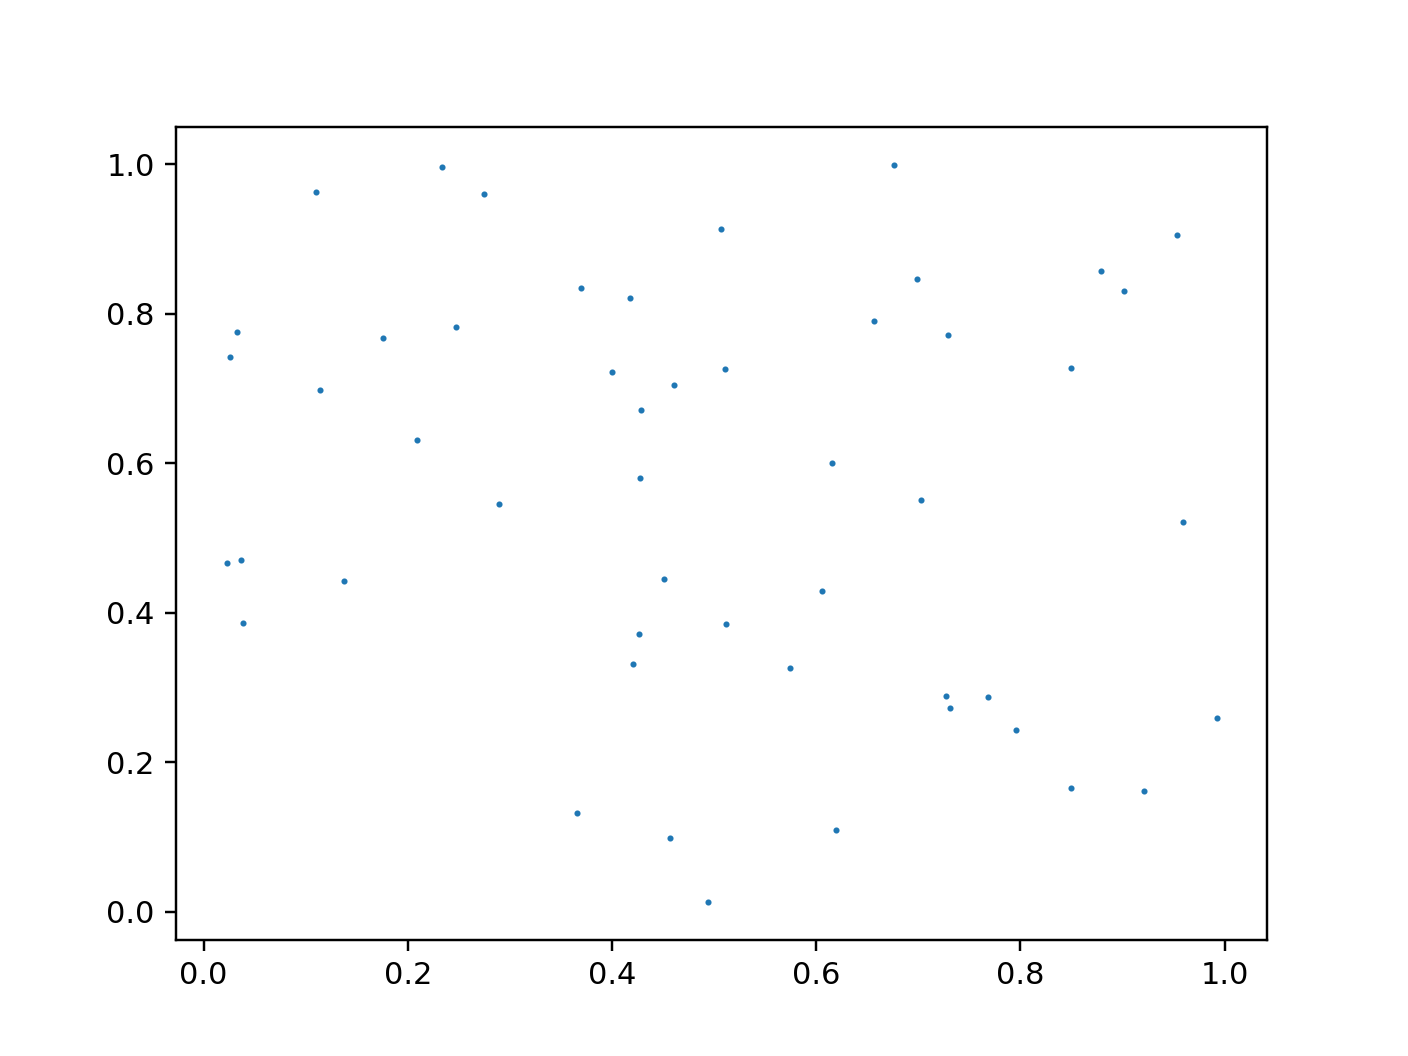

In [63]:
"""
dim = '2d'
fullpathf = "../data/dtlz2-nbi/{0:s}/dataf.csv".format(dim)
# fullpathf = "../data/dtlz2/{0:s}/dataf.csv".format(dim)
# fullpathf = "../data/debmdk-all-nbi/{0:s}/dataf.csv".format(dim)
# fullpathf = "../data/debmdk-all/{0:s}/dataf.csv".format(dim)
# fullpathf = "../data/dtlz8-nbi/{0:s}/dataf.csv".format(dim)
# fullpathf = "../data/dtlz8/{0:s}/dataf.csv".format(dim)

path, filenamef = os.path.split(fullpathf)
dirs = path.split('/')
frontname = dirs[-2]

F = np.loadtxt(fullpathf, delimiter=',')
"""

np.random.seed(2222)
F = np.random.random([50,2])

# Plot
if dim == "2d":
    fig = plt.figure()
    ax = fig.gca()
    ax.scatter(F[:,0], F[:,1], s=1)
    plt.show()
else:
    fig = plt.figure()
    ax = Axes3D(fig)
    ax.scatter(F[:,0], F[:,1], F[:,2], s=1)
    plt.show()

Doing spatial.Delaunay triangulation...
Finished spatial.Delaunay triangulation (Elapsed Time 0.000537)
Building alpha filtration...
Finished building alpha filtration (Elapsed Time 0.028143)
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
0.007154516606566854 3.2487444268186074 0.15561638661938898 0.40492418842061895


<IPython.core.display.Javascript object>


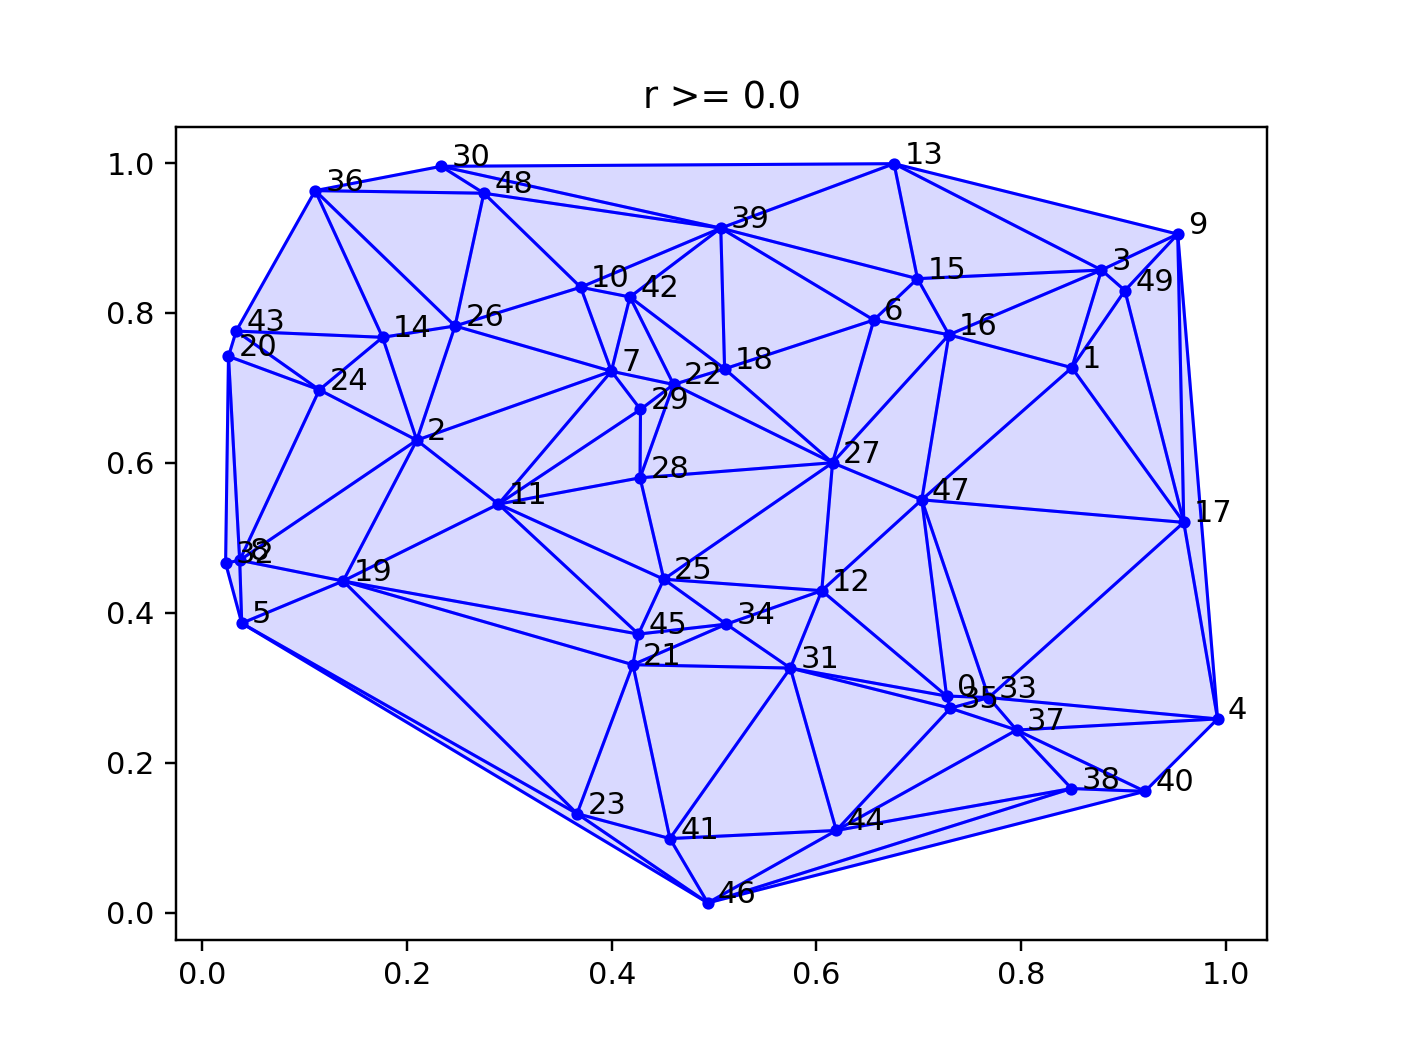

<IPython.core.display.Javascript object>


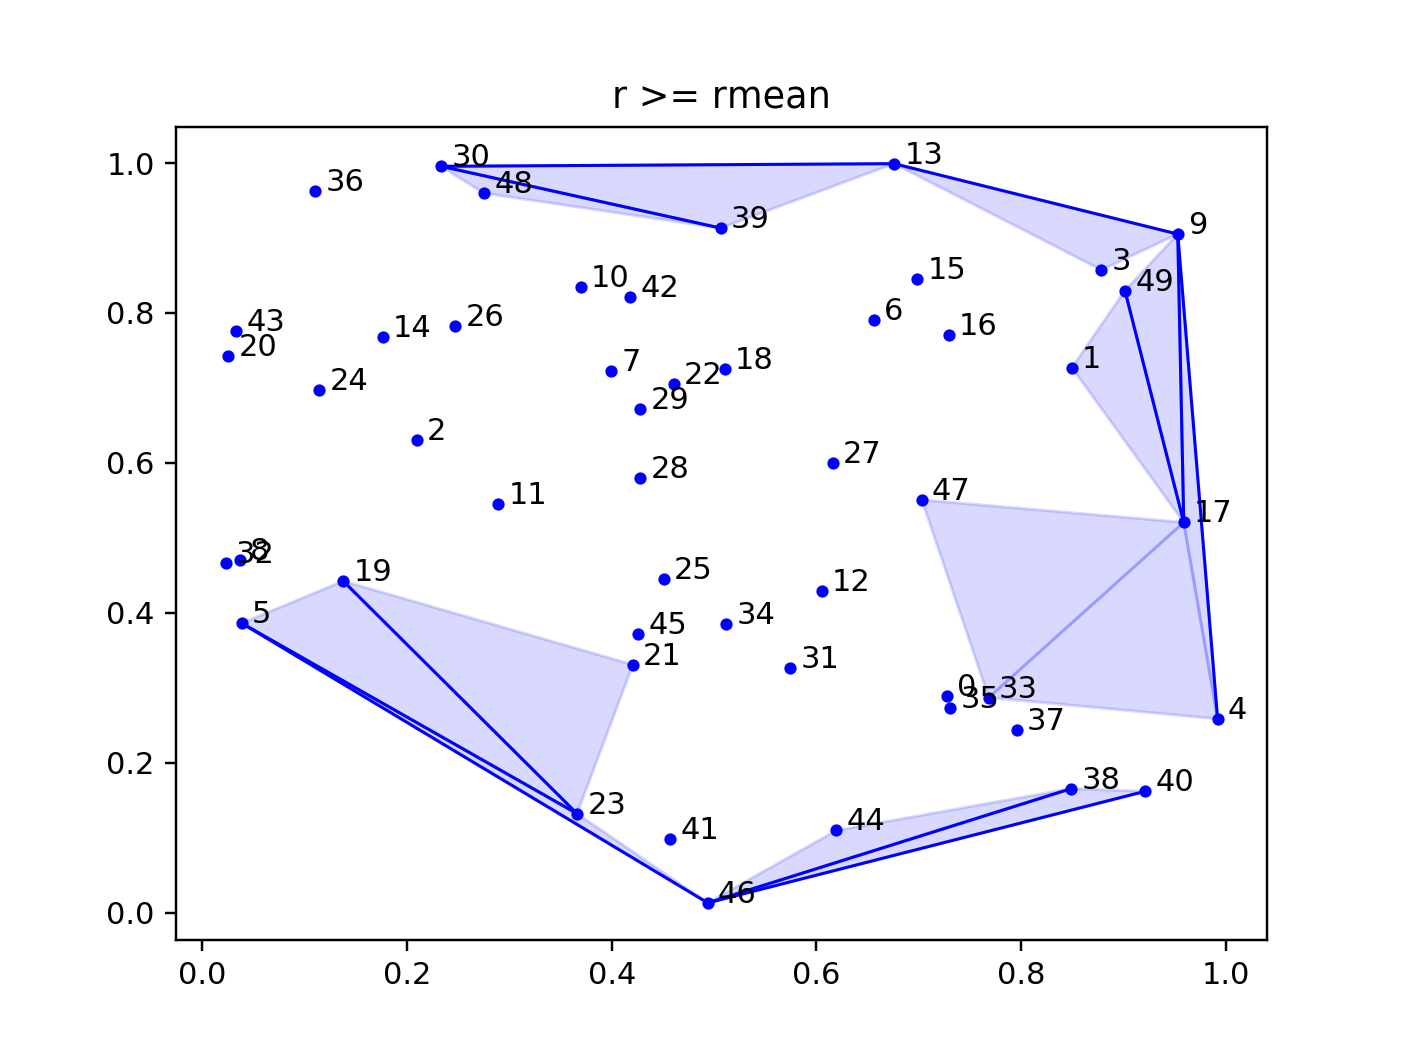

In [81]:
def draw_simplex(F, sigma):
    idx, r = sigma
    if len(idx) > 2:
        ax.fill([F[idx[0],0], F[idx[1],0], F[idx[2],0]], \
                [F[idx[0],1], F[idx[1],1], F[idx[2],1]], alpha=0.15, color='blue')
        ax.plot([F[idx[0],0], F[idx[1],0]], [F[idx[0],1], F[idx[1],1]], color='blue', linewidth=1)
        
    if len(idx) == 1:
        ax.plot([F[idx[0],0]], [F[idx[0],1]], marker='o', markersize=3, color='blue')
        ax.text(F[idx[0],0]+0.01, F[idx[0],1], s="{:d}".format(idx[0]))
    elif len(idx) == 2:
        
def plot_faces(F, sigmas, title, ax=None, cond=lambda x,y: True):
    for sigma in sigmas:
        idx,r = sigma
        if len(idx) == 1:
                ax.plot([F[idx[0],0]], [F[idx[0],1]], marker='o', markersize=3, color='blue')
                ax.text(F[idx[0],0]+0.01, F[idx[0],1], s="{:d}".format(idx[0]))
        if cond(r,y):
            if len(idx) == 2:
                ax.plot([F[idx[0],0], F[idx[1],0]], [F[idx[0],1], F[idx[1],1]], color='blue', linewidth=1)
            elif len(idx) == 3:
                ax.fill([F[idx[0],0], F[idx[1],0], F[idx[2],0]], \
                        [F[idx[0],1], F[idx[1],1], F[idx[2],1]], alpha=0.15, color='blue')
    ax.set_title(title)
    

sigmas = build(F)
r = np.array([s[1] for s in sigmas])
print(r[0:10])
rmin = np.min(r[r > 0])
rmax = np.max(r[r > 0])
rmean = np.mean(r[r > 0])
rstd = np.std(r[r > 0])
print(rmin, rmax, rmean, rstd)

ax = plt.figure().gca()
t = 0.0
plot(F, sigmas, "r >= 0.0", ax=ax, cond=lambda x,rmean: )
plt.show()

ax = plt.figure().gca()
t = rmean
plot(F, sigmas, "r >= rmean", ax=ax, threshold=t)
plt.show()

ax = plt.figure().gca()
t = rmean
plot(F, sigmas, "r < rmean", ax=ax, threshold=t)
plt.show()



In [ ]:
(f1/d - f2/d) / (F1/D - F2/D) = df/d / dF/D = df/d * D/dF = df/dF * D/d > e -> df/DF > e * d/D 